# US Census Data Exploration
### Retima Dangol
The Goal of the following notebook is to explore the a US census dataset, and create a model to predict the whether a person will make greater than of less that 50,000 dollars.  The notebook is broken into the following sections.

<a class=big href='#step1'>1) Data Loading</a>  
<a class=big href='#step2'>2) Exploratory Analysis</a>  
<a class=big href='#step3'>3) Feature Engineering</a>  
<a class=big href='#step4'>4) Initial Model Attempts</a>   
<a class=big href='#step5'>5) Model Disucssion & Improvement</a>  
<a class=big href='#step6'>6) Model Applied to test file</a>    

In [1]:
# IMPORT STATEMENTS 
import re

import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as ss
import matplotlib.pyplot as plt

import json

import helpers           # contains function separetly to keep notebook clean
!python --version        # see requirements.txt for more specifics

Python 3.7.3


In [96]:
# ADDITIONAL NOTEBOOK SETUP
helpers.css_styling()    # Add styling for markdown cells for readability

In [3]:
# CONSTANT DECLARATIONS
TRAIN_FILE_PATH = "census_income_learn.csv"
TEST_FILE_PATH = "census_income_test.csv"
METADATA_FILE_PATH = "census_income_metadata.txt"

## <a id='step1'></a>1) Data Loading  
The following section tackles reading the data in from the provided files and a bit of preprocessing

In [4]:
# Bring in train and test data
train_df = pd.read_csv(TRAIN_FILE_PATH, header=None)
test_df = pd.read_csv(TEST_FILE_PATH, header=None)

In [5]:
print("Train File has {:,} rows and {:,} columns".format(*train_df.shape))
print("Test File has {:,} rows and {:,} columns".format(*test_df.shape))

Train File has 199,523 rows and 42 columns
Test File has 99,762 rows and 42 columns


In [6]:
train_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.


<div class=discuss>
The dataframe does not have a header row, which although not stricitly necessary, makes it easier to discuss the model that is created and makes it easier to engineer novel features. The metadata file is a bit odd with the code mapping section having some mispellings and missing some columns so that was ignored, the distinct count metatdata section doesnt exactly specify the order of the columns since it forgets about the instance feature. The instance feature is discussed in the final section of the metadata but this section again is missing some columns. So a bit of a manual approach is needed even with trying to parse the column names from the metadata file.
</div>

In [7]:
# Parse column info out of metadata file
col_info = {}
re_info_line = r'\| +([0-9]+) distinct values for attribute #([0-9]+) \(([a-zA-Z\-0-9\' ]+)\) ([a-z]+)'

with open(METADATA_FILE_PATH, 'r') as lines:
    for line_num, line in enumerate(lines):
        if  (line_num > 80) & (line_num < 121):
            distinct_count, col_num, col_descr, kind = re.match(re_info_line, line).groups()
            col_info[col_descr] = {'distinct_count': int(distinct_count),
                                   'col_num': int(col_num),
                                   'kind': kind}

In [8]:
# Generate a simple list of column name, manually add in instance weight and target
col_names = sorted([key for key in col_info], key=lambda x: col_info[x]['col_num'])
col_names.insert(24, 'instance weight')
col_names.append('target')

In [9]:
# Check that the columns names in the proper spot
for col_name, col_ind in zip(col_names, train_df.columns):
    if col_name in col_info:
        unique_count = train_df[col_ind].unique().__len__()
        should_be_count = col_info[col_name]['distinct_count']
        if unique_count != should_be_count:
            print(f'{col_name}:{should_be_count} and {col_ind}:{unique_count} do not match')
    else:
        print(f"No info {col_name}")

No info instance weight
No info target


<div class=discuss>
The above just checks the metadata claims distinct count with the actual to make sure this was assigned properly. No information on instance wieght and target were in this section so those have no comparison
</div>

In [10]:
# Assign columns names to both dataframes 
train_df.columns = test_df.columns = col_names

In [13]:
# Make sure some of the categorical columns that use nominal numeric example:'year' are strings and not continous 
for col_name, info in col_info.items():
    if info['kind'] == 'nominal':
        train_df[col_name] = train_df[col_name].astype(str)
        test_df[col_name] = test_df[col_name].astype(str)

# Make a simpler target
train_df['target'] = train_df['target'].apply(lambda x: '0' if '-' in x else '1')
test_df['target'] = test_df['target'].apply(lambda x: '0' if '-' in x else '1')

# Useful to have these defined for exploration
numerical_columns = train_df.select_dtypes(exclude=['object']).columns
categorical_columns = train_df.select_dtypes(include=['object']).columns

<div class=discuss>
The above converts all features to what the metadata file states they should be treated as and maps the target to 1 = gt 50k, 0 = lt 50k
</div>

## <a id='step2'></a>2) Exploratory Analysis  
The following section quickly explores some of the features available before jumping into modeling so that informed decisions can be made about possible ways to improve the model.

In [14]:
print(f"Categorical Features: {len(categorical_columns)}")
print(f"Continuous Features: {len(numerical_columns)}")

Categorical Features: 34
Continuous Features: 8


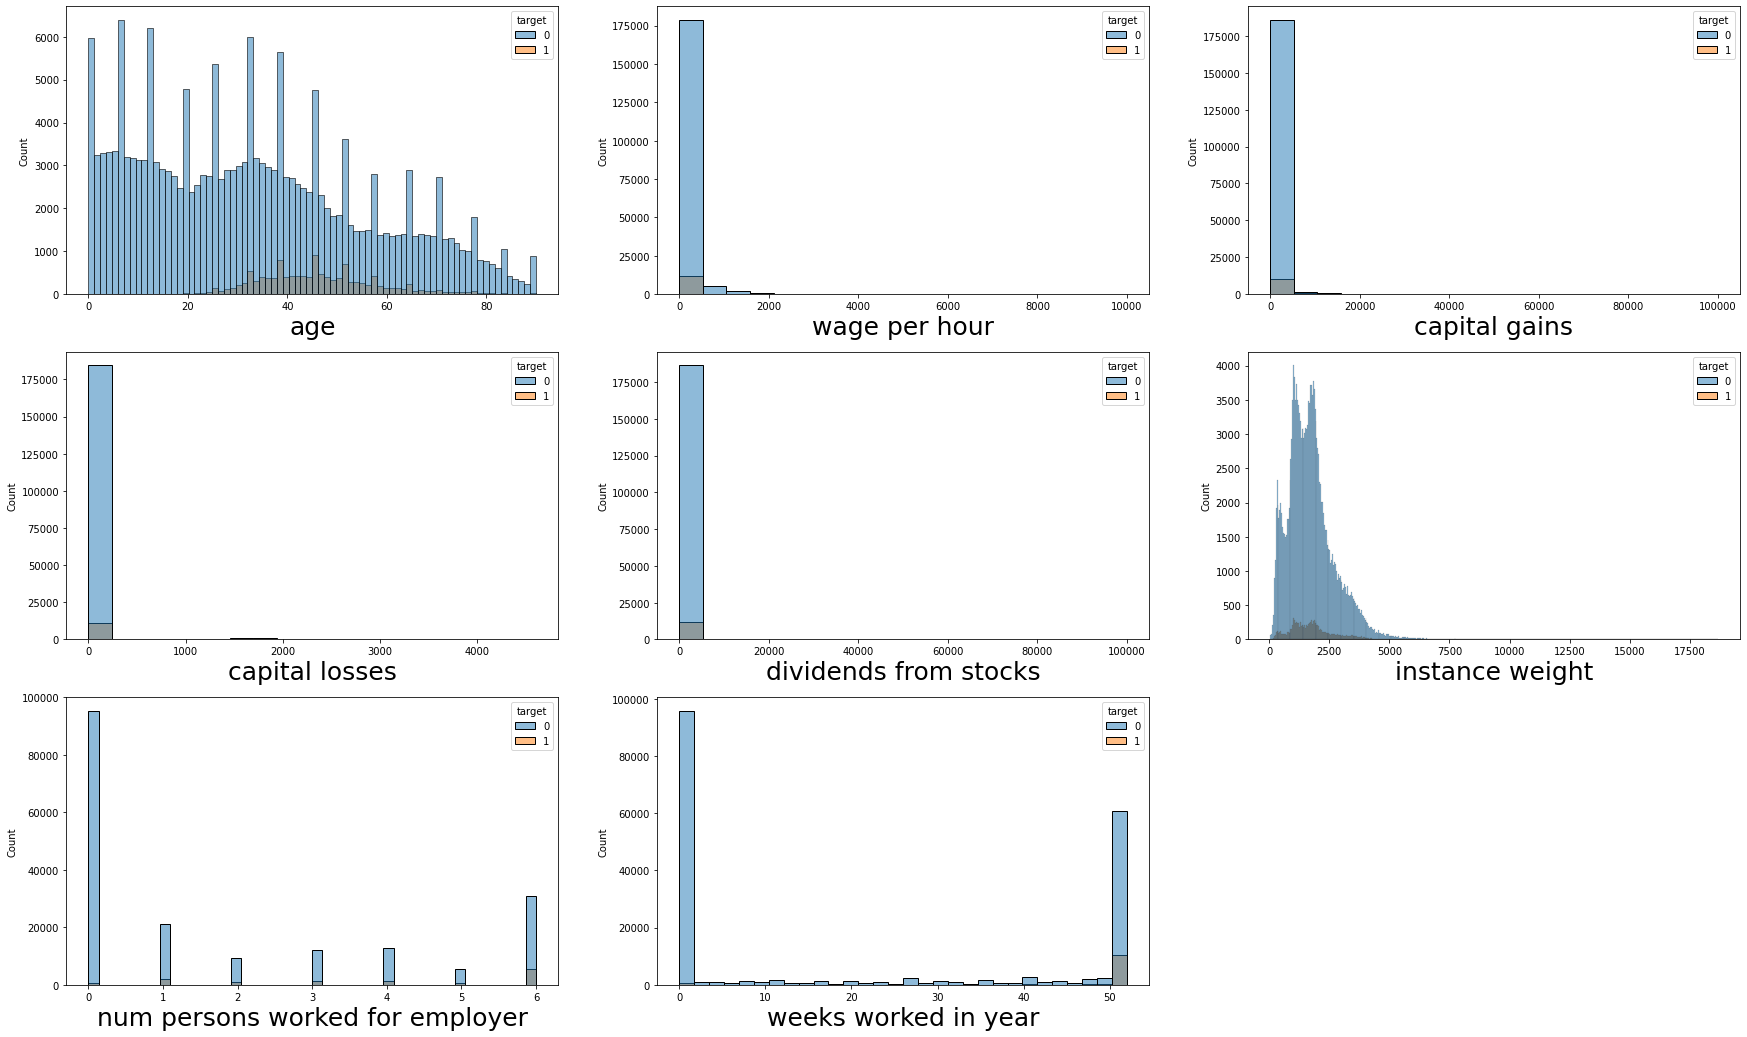

In [16]:
# Plot the histograms of all the continuous variables
fig, axes = plt.subplots(3, 3, figsize=(30, 18))
for ax, col_name in zip(axes.flatten(), numerical_columns):
    sns.histplot(data=train_df, x=col_name, ax=ax,  hue="target")
    ax.xaxis.label.set_size(25)
axes.flatten()[-1].set_visible(False)

<div class=discuss>
A few nicely distributed continuous features above. Some like "wage per hour", "capital gains", and "capital losses" are thrown off by some outliers, and something like "weeks worked in a year" has some obvious peaks that might work better as a categorical rather than a continuous feature.
</div>

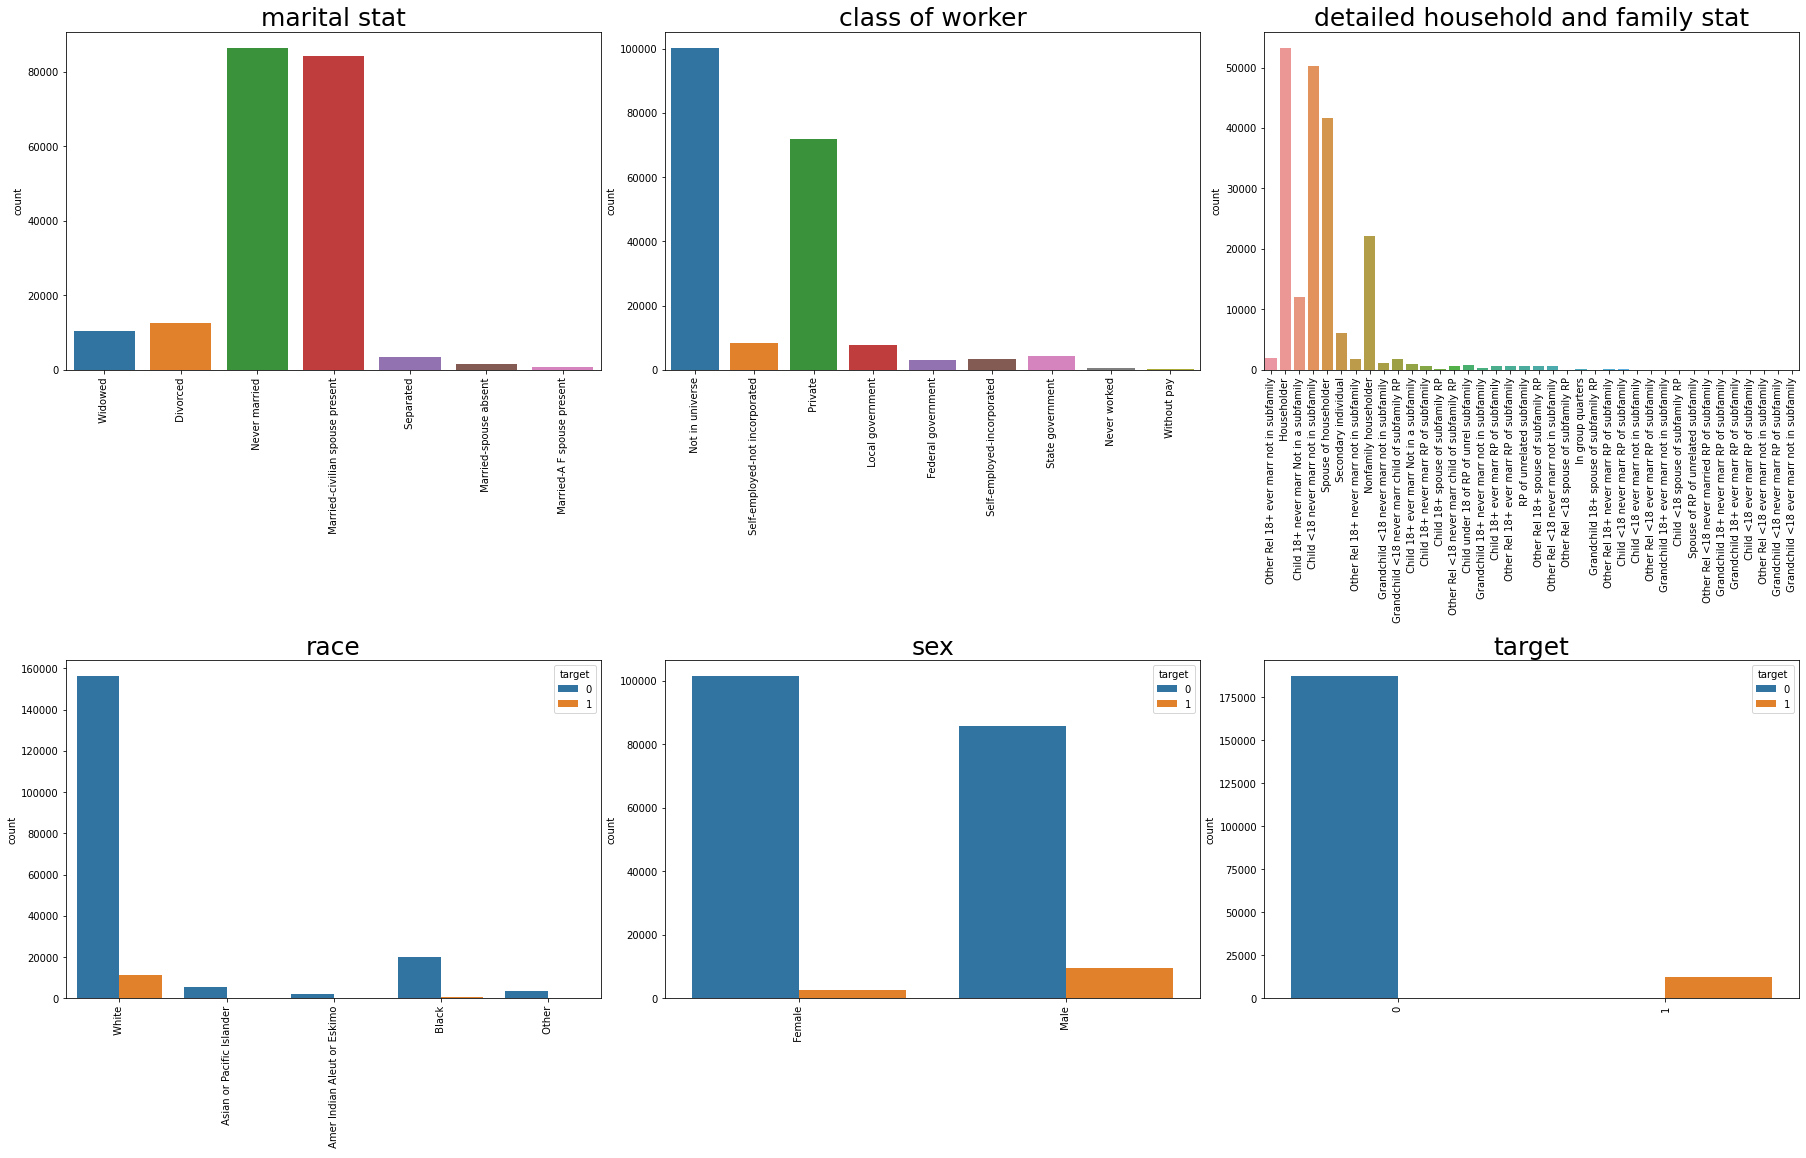

In [17]:
# Plot countplots(barplots) of all categorical features
# Change bool to see all categorical features
all_cols = False

a_few_interesting = ['marital stat', 'class of worker', 'detailed household and family stat',
                     'race', 'sex', 'target']
selection = categorical_columns 

selection = categorical_columns if all_cols else a_few_interesting
rows = round((len(selection) / 3) + .5)

fig, axes = plt.subplots(rows, 3, figsize=(25, rows * 8))
for ax, col_name in zip(axes.flatten(), selection):
    if len(train_df[col_name].unique()) <= 5:
        sns.countplot(data=train_df, x=col_name, ax=ax, hue='target')
    else:
        sns.countplot(data=train_df, x=col_name, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)
    ax.set_xlabel('')
    ax.set_title(col_name, fontsize=25)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

<div class=discuss>
The above can be changed to show a few or all of the columns, but there are many so a selection is used instead, but all were quickly examined at one point. Some of the categoricals have only a few distinct values, some have many. If using a standard one-hot encoding then this could result in quite a few features for the algorithms to deal with. Because of all the distinct categories using something like target encoding is probably beneficial. 
</div>

<div class=discuss>
The target is imbalanced.
</div>

### [Target Encoding Documentation](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-munging/target-encoding.html#target-encoding)

### Correlation plot for numerical data 

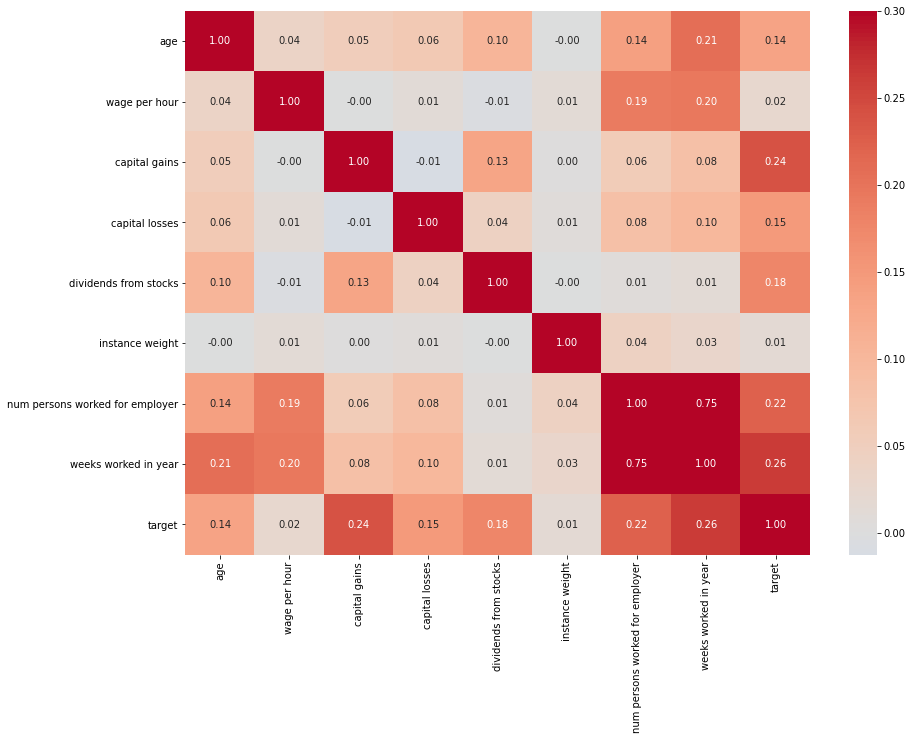

In [18]:
# Plot of continuous variables correlations
temp_cols = numerical_columns.insert(len(numerical_columns), 'target')
train_df['target'] = train_df['target'].astype(int)         # quick change so corr works with target
fig, ax = plt.subplots(figsize=(14,10))
corr = train_df[temp_cols].corr()
sns.heatmap(corr, vmax=.3, center=0, annot=True, fmt='.2f', cmap='coolwarm', ax=ax);

<div class=discuss>
Most of the continuous features are not higly correlated, so they might all have some unique signal to provide the model. There are also some moderate correlations with the target so that is a good sign that we will be able to find some signal.
</div>

### Plot correlation of categorical variables

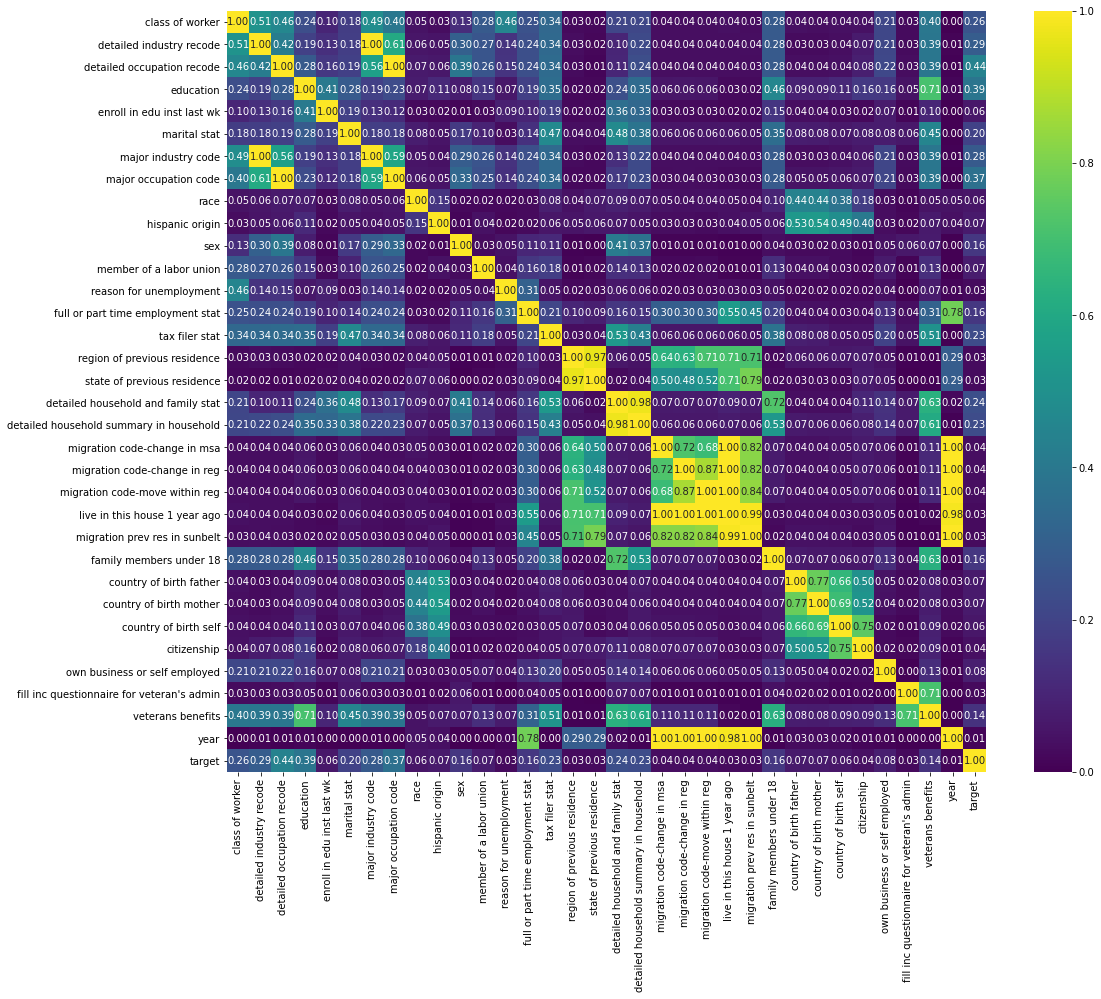

In [19]:
# categorical correlation is less well defined in standard libraries, but many people have implementations
# to do this, one is coded in the helpers module and used here to assist in this visual
train_df['target'] = train_df['target'].astype(str)    # change back from earlier
corr_vals, cat_columns = helpers.cat_correlation_heatmap(train_df)
fig, ax = plt.subplots(figsize=(17, 14))
sns.heatmap(corr_vals, xticklabels=cat_columns, yticklabels=cat_columns, annot=True, fmt='.2f', cmap='viridis');

<div class=discuss>
The highest correlated feature with the target is education, which makes intuitive sense. Some of the categoricals that have very similar names are also highly correlated with one another, and if there was a reason to remove redundant features they might make good candidates. Of note is that year is highly correlated with the migration features and part time employment stat, considering there is only 2 years of data this is interesting -  this can be researched but won't help a model that tries to predict the future, unless a different way to capture what is occuring is found.
</div>

#### [Article on US economy during the 1990s](https://en.wikipedia.org/wiki/1990s_United_States_boom)

### Typical Target Personas

In [20]:
mask1 = train_df['target'] == '1'
typical_gt_50k = train_df[mask1].describe(include=["O"]).loc['top']
typical_lt_50k = train_df[~mask1].describe(include=["O"]).loc['top']

In [21]:
print(typical_gt_50k)

class of worker                                                          Private
detailed industry recode                                                      45
detailed occupation recode                                                     2
education                                             Bachelors degree(BA AB BS)
enroll in edu inst last wk                                       Not in universe
marital stat                                     Married-civilian spouse present
major industry code                                  Manufacturing-durable goods
major occupation code                             Executive admin and managerial
race                                                                       White
hispanic origin                                                        All other
sex                                                                         Male
member of a labor union                                          Not in universe
reason for unemployment     

<div class=discuss> 
^^^ The most common characteristics of a person in the greater than 50k group
</div>

In [22]:
print(typical_lt_50k)

class of worker                                                      Not in universe
detailed industry recode                                                           0
detailed occupation recode                                                         0
education                                                                   Children
enroll in edu inst last wk                                           Not in universe
marital stat                                                           Never married
major industry code                                      Not in universe or children
major occupation code                                                Not in universe
race                                                                           White
hispanic origin                                                            All other
sex                                                                           Female
member of a labor union                                          

<div class=discuss> 
^^^ The most common characteristics of a person in the less than 50k group - Some of these arent too surprising and just make up the majority of the sample regardless of which group they fall into, others make intutive sense such as the greater than group having a bachelors in education and the less than group being made up of children. A similar thing could be done with the continuous features.
</div>

In [20]:
nan_count = train_df.isnull().sum().sum()
print(f"nan Count: {nan_count}")

nan Count: 0


Looks like there is not any missing data to account for

## <a id='step3'></a>3) Feature Engineering  
After looking at the data during exploration a few ideas to alter or create new features is applied.

##### Education - Remapping to reduce categories

In [25]:
# Education was highly correlatted but had lots of small groups, might benefit from more sensible bins
pre_map_count = len(train_df['education'].unique())
pre_corr = helpers.cramers_v(train_df['education'], train_df['target'])

train_df['fe_education_mapped'] = train_df['education'].map(helpers.education_mapping)
test_df['fe_education_mapped'] = test_df['education'].map(helpers.education_mapping)

post_map_count = len(train_df['fe_education_mapped'].unique())
post_corr = helpers.cramers_v(train_df['fe_education_mapped'], train_df['target'])

print(f"Education groups reduced from {pre_map_count} to {post_map_count}")
print(f"Pre Correlation: {pre_corr:.3f}    Post Correlation: {post_corr:.3f}")

Education groups reduced from 17 to 11
Pre Correlation: 0.390    Post Correlation: 0.389


<div class=discuss>
A reduction in possibilities without much drop in correlation should help reduce complexity without signal loss. The prefix of FE attached to new feature is to help distiguish from untouched raw features.
</div>

##### Net Capital Change - consolidate 2 continuos features to single feature

In [26]:
# Net Capital Change = Capital Gains - Capital Loss
train_df['fe_net_capital'] = train_df['capital gains'] - train_df['capital losses']
test_df['fe_net_capital'] = test_df['capital gains'] - test_df['capital losses']

##### Employment_cat - bimodal weeks worked in year to categorical

In [27]:
# This feature had lots at the bottom, lots at top, and bunch spread though middle
train_df['fe_employment_cat'] = train_df['weeks worked in year'].apply(helpers.weeks_work_map)
test_df['fe_employment_cat'] = test_df['weeks worked in year'].apply(helpers.weeks_work_map)
print(train_df['fe_employment_cat'].value_counts())

unemployed    95983
full_time     75752
part_time     27788
Name: fe_employment_cat, dtype: int64


##### Categorical encoding

<div class=discuss>
This dataset is highly categorical and these need to be transformed in some manner. A standard option is one hot encoding where a categorical feature gets transformed into many columns with 0 or 1 if the category was present. Another option gaining more popularity is target encoding. This uses information about the target to transform the category into a float, thus preserving and increasing information and keeping the feature in a single column. From here on forward h2o is used for transformation and modeling.
</div>

In [29]:
import h2o
from h2o.estimators import H2OTargetEncoderEstimator
train_size = 0.8
random_seed = 453

h2o.init(max_mem_size='5G')

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,13 secs
H2O_cluster_timezone:,America/Denver
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.1
H2O_cluster_version_age:,1 month and 23 days
H2O_cluster_name:,H2O_from_python_rdangol_ltdftd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4.430 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [30]:
# Account for datatype differences and transorm to h2o frame
pd_col_types = train_df.dtypes.apply(lambda x: x.name).to_dict()
df_to_h2o_type_map = {'object':'enum', 'int64': 'int', 'float64':'real'}
h2o_col_types = {key: df_to_h2o_type_map[val] for key, val in pd_col_types.items()}
hdf_train = h2o.H2OFrame(train_df, column_types=h2o_col_types)
hdf_test = h2o.H2OFrame(test_df, column_types=h2o_col_types)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [31]:
# Specify feature type for appropriate handling later
response = 'target'
cat_columns = [x for x, y  in hdf_train.types.items() if y == 'enum' and x != response]
num_columns = [x for x, y  in hdf_train.types.items() if y in ['int', 'real'] and x != response]

hdf_train, hdf_valid = hdf_train.split_frame([train_size], seed=random_seed)

In [32]:
# Target encoding for categorical features
fold_column = "kfold_column"
hdf_train[fold_column] = hdf_train.kfold_column(n_folds=5, 
                                        seed=random_seed)

data_te = H2OTargetEncoderEstimator(fold_column=fold_column,
                                    data_leakage_handling='k_fold',
                                    blending=True)

data_te.train(x=cat_columns,
              y=response,
              training_frame=hdf_train)

# New target encoded train and test sets
hdf_train_te = data_te.transform(frame=hdf_train, seed=random_seed)
hdf_valid_te = data_te.transform(frame=hdf_valid, noise=0.0)
hdf_test_te = data_te.transform(frame=hdf_test, noise=0.0)

# new categorical column names
te_columns = [f"{col}_te" for col in cat_columns]

targetencoder Model Build progress: |█████████████████████████████████████| 100%


In [33]:
# Target Encoding Example
olds = hdf_train_te.as_data_frame()['sex'].to_list()[:8]
news = hdf_train_te.as_data_frame()['sex_te'].to_list()[:8]
for old, new in zip(olds, news):
    print(f"{old} --> {new:.3f}")

 Female --> 0.031
 Female --> 0.034
 Female --> 0.032
 Male --> 0.100
 Female --> 0.024
 Female --> 0.033
 Male --> 0.109
 Female --> 0.030


<div class=discuss>
Now we have h2o frames for the training, to validate the training, and to test on when a final model is selected. The categorical columns have been transformed into floats, the example above shows how the train set has taken the string values and replaced it with the percentage of that value that is in the targets postive class. The valiues are a bit adjusted with some noise. The raw features are still in the dataset and when included h2o uses 1 hot encoding on them so no 1 hot encoding is needed to use them.
</div>

## <a id='step4'></a>4) Initial Models  
A few quick models can be made to see how they perform. Later improvements can be made to the models that do well.

In [34]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators import H2OXGBoostEstimator
from h2o.estimators import H2OSupportVectorMachineEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators import H2ORandomForestEstimator

In [36]:
# A few different feature set options to try and distiguish if feature engineering and target encoding helps
predictors_raw = [col for col in cat_columns + num_columns if 'fe' not in col]
predictors_raw_te = [col for col in te_columns + num_columns if 'fe' not in col]
predictors_fe = [col for col in cat_columns + num_columns]
predictors_fe_te = [col for col in te_columns + num_columns]
features = [('raw', predictors_raw),
            ('raw_te', predictors_raw_te),
            ('fe', predictors_fe),
            ('fe_te', predictors_fe_te)
           ]

In [37]:
# Cyle through a few models and record results for comparison
h2o.no_progress()
simple_models = [('gbm_model', H2OGradientBoostingEstimator()),
                 ('xgb_model', H2OXGBoostEstimator()),
                 ('glm_model', H2OGeneralizedLinearEstimator()),
                 ('drf_model', H2ORandomForestEstimator())
                ]

f1s = np.zeros((4,4))
accs = np.zeros((4,4))
for model_ind, model in enumerate(simple_models):
    m_name, model = model
    for feature_ind, feature in enumerate(features):
        f_name, predictors = feature
        model.train(x=predictors, y=response, training_frame=hdf_train_te, validation_frame=hdf_valid_te)
        f1_score_thresh, f1_score = model.F1(valid=True)[0]
        acc_thresh, acc_score = model.accuracy(valid=True)[0]
        f1s[model_ind][feature_ind] = f1_score
        accs[model_ind][feature_ind] = acc_score

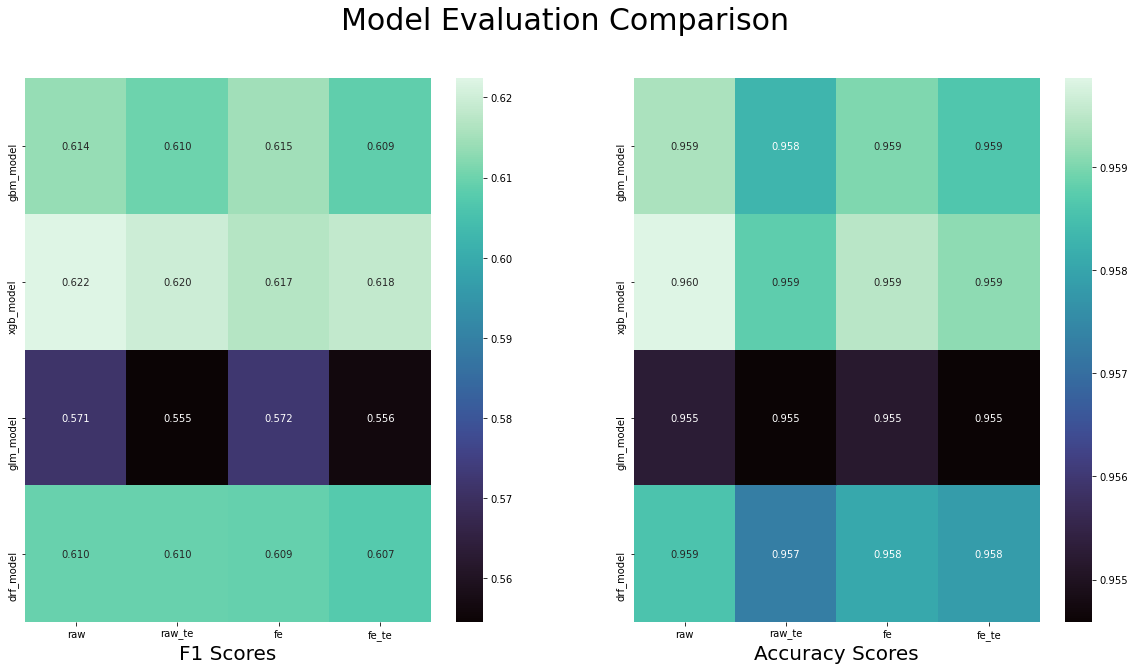

In [40]:
# Plot the above models scoring results
fig, ax = plt.subplots(1,2, figsize=(20,10))
xticks = [f[0] for f in features]
yticks = [m[0] for m in simple_models]
sns.heatmap(f1s, annot=True, fmt='.3f', cmap='mako', ax=ax[0], xticklabels=xticks, yticklabels=yticks)
sns.heatmap(accs, annot=True, fmt='.3f', cmap='mako', ax=ax[1], xticklabels=xticks, yticklabels=yticks)
ax[0].set_xlabel('F1 Scores', size=20)
ax[1].set_xlabel('Accuracy Scores', size=20)
fig.suptitle('Model Evaluation Comparison', size=30);

<div class=discuss>
F1 score was chosen due to the imbalanced nature of the target. Accuracy is also included due to its easy interpretability. In this case with a highly skewed target a high accuracy can simply be achieved by picking the negative class for all predictions. The F1 score helps judge models by combining the precision and recall into a signal metric that can be used for model selection. Another desired characteristic of F scores is that is can be altered to weight the false positives or false negatives more so that in situations when the "cost" of the different types of errors is known, this can be included in the model evaluation to pick the model most appropriate for the use case. 
</div>

#### [F1 Score Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)

## <a id='step5'></a>5) Model Discussion / Selection / Improvement

#### Picking the best two performing model from grid above
- XGBoost
- GBM
 
A grid search was preformed to pick the best hyper parameters for those model. This is was done in a separate notebook and best parameters were saved off for usage here.

```grid_search.ipynb```

In [42]:
# Save for usage by other notebook
data_for_grid_search = hdf_train_te.as_data_frame()
data_for_grid_search.to_csv('grid_search.csv')

data_types = hdf_train_te.types 
with open("grid_search_data_type.json", 'w') as json_file:
    json_file.write(json.dumps(data_types, indent=4))

### Loading GBM | XGB grid searched parameters:

In [43]:
with open("hyperparams/gbm_grid_param.json", "r") as f_handle:
    gbm_hyper_params = json.load(f_handle)

remove_params = ['response_column','ignored_columns','model_id','training_frame',
                 'validation_frame','calibration_frame','seed']

gbm_params = {key: gbm_hyper_params[key] for key in gbm_hyper_params if key not in remove_params}

In [44]:
with open("hyperparams/xgb_grid_param.json", "r") as f_handle:
    xgb_hyper_params = json.load(f_handle)

remove_params = ['response_column','ignored_columns','model_id','training_frame',
                     'validation_frame','calibration_frame','seed']

xgb_params = {key: xgb_hyper_params[key] for key in xgb_hyper_params if key not in remove_params}

### Final run to pick our best top two model with grid search parameters

In [45]:
h2o.no_progress()
xgb_better_params = xgb_params
gbm_better_params = gbm_params
better_models = [('gbm_model', H2OGradientBoostingEstimator()),
                 ('xgb_model', H2OXGBoostEstimator()),
                 ('gbm_model_gs', H2OGradientBoostingEstimator(**gbm_better_params)),
                 ('xgb_model_gs', H2OXGBoostEstimator(**xgb_better_params))
                ]

f1s = np.zeros((4,4))
accs = np.zeros((4,4))
for model_ind, model in enumerate(better_models):
    m_name, model = model
    for feature_ind, feature in enumerate(features):
        f_name, predictors = feature
        model.train(x=predictors, y=response, training_frame=hdf_train_te, validation_frame=hdf_valid_te)
        f1_score_thresh, f1_score = model.F1(valid=True)[0]
        acc_thresh, acc_score = model.accuracy(valid=True)[0]
        f1s[model_ind][feature_ind] = f1_score
        accs[model_ind][feature_ind] = acc_score

### Plotting Final Results

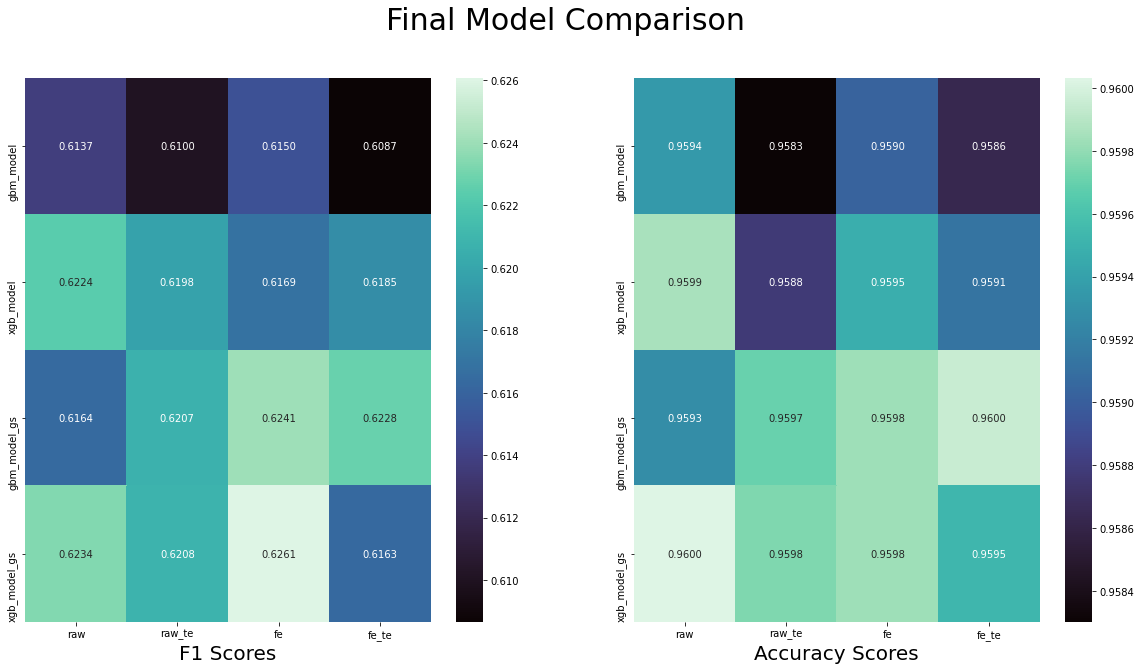

In [47]:
fig, ax = plt.subplots(1,2, figsize=(20,10))
xticks = [f[0] for f in features]
yticks = [m[0] for m in better_models]
sns.heatmap(f1s, annot=True, fmt='.4f', cmap='mako', ax=ax[0], xticklabels=xticks, yticklabels=yticks)
sns.heatmap(accs, annot=True, fmt='.4f', cmap='mako', ax=ax[1], xticklabels=xticks, yticklabels=yticks)
ax[0].set_xlabel('F1 Scores', size=20)
ax[1].set_xlabel('Accuracy Scores', size=20)
fig.suptitle('Final Model Comparison', size=30);

<div class=discuss>
The above shows how the best model based on f1 score currently is the xgb model with the gridsearched parameters and the engineered features but not the target encoding. The best model based on accuracy score is the bgm model with gridsearched parameters, engineered features and target encoding. Some of the models are very close though and between multiple runs this sometimes changed due to different random elements. The first time through the best model based on F1 score was the GBM model with feature engineering and target encoding so this is used in the final section. The gridsearching can be seen to have found better parameters over the default ones.
</div>

# <a id='step6'></a>6) Apply to Test Data  
Now that a final improved model exists it can be used on the test data set rather than the validation portion of the training dataset used above.

In [50]:
gbm_model_final = better_models[2][1]
test_model_perform = gbm_model_final.model_performance(hdf_test_te)

print('F1 score on Test Data: {:.4f}'.format(test_model_perform.F1()[0][1]), '\n')
print('Accuracy score on Test Data: {:.4f}'.format(test_model_perform.accuracy()[0][1]))

F1 score on Test Data: 0.6265 

Accuracy score on Test Data: 0.9577


<div class=discuss>
Since the F1 score for this unseen test data is very similar to the score obtained to validation data thus the model is not overfit.
</div>

## Feature Importance

Now that the model is created it can be examined to learn more about what contributes to what we are trying to predict. Feature_frequencies is the number of times a feature was used on a prediction path in a tree model.
#### [Feature Frequency Documentation](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/performance-and-prediction.html#predict-feature-frequency)

In [52]:
feature_freq = gbm_model_final.feature_frequencies(hdf_test_te).as_data_frame()

## sorted average for each variable 

sorted_frequency = feature_freq.describe().loc['mean'].sort_values(ascending= False)

#### Plotting the average of the frequency of variable used

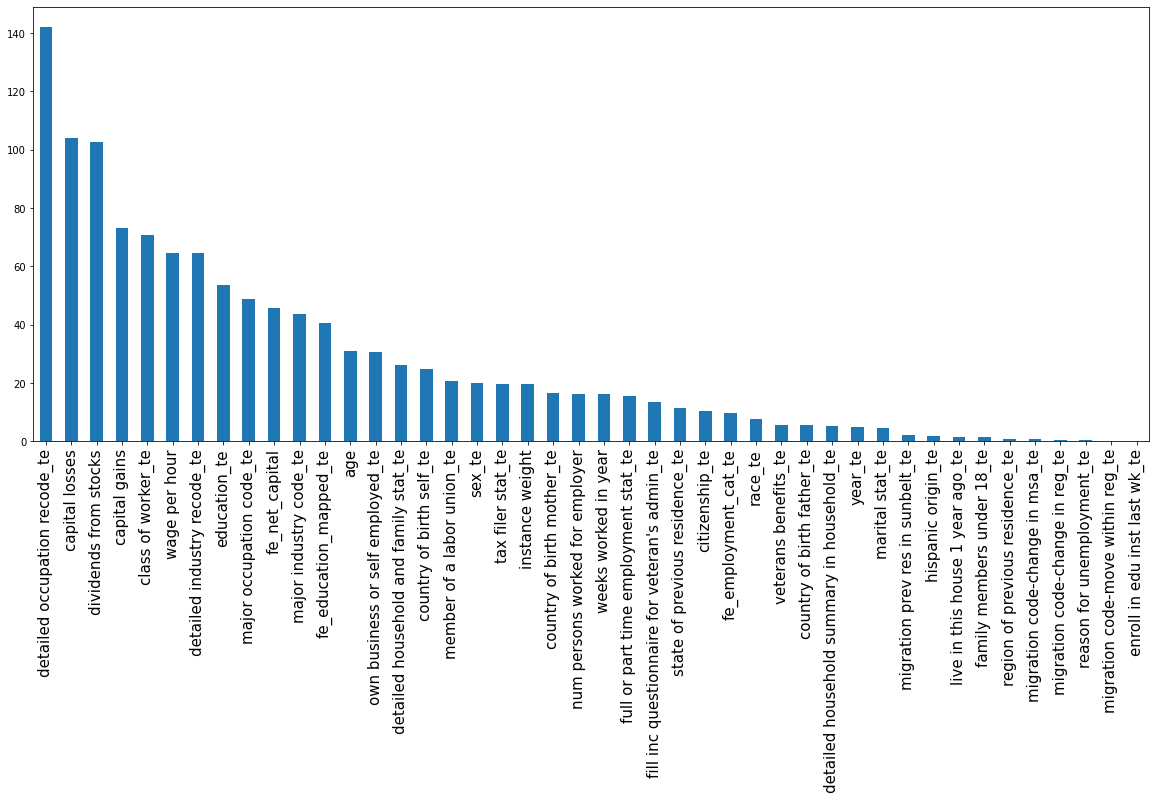

In [60]:
fig, ax = plt.subplots(figsize=(20,8))
sorted_frequency.plot(ax=ax, kind = 'bar')
plt.xticks(fontsize=15);

### Variable importance GBM
```
Variable importance is determined by calculating the relative influence of each variable: 
whether that variable was selected to split on during the tree building process, 
and how much the squared error (over all trees) improved (decreased) as a result. 
```
#### [Variable Importance Documentation](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/variable-importance.html#variable-importance-calculation-gbm-drf)

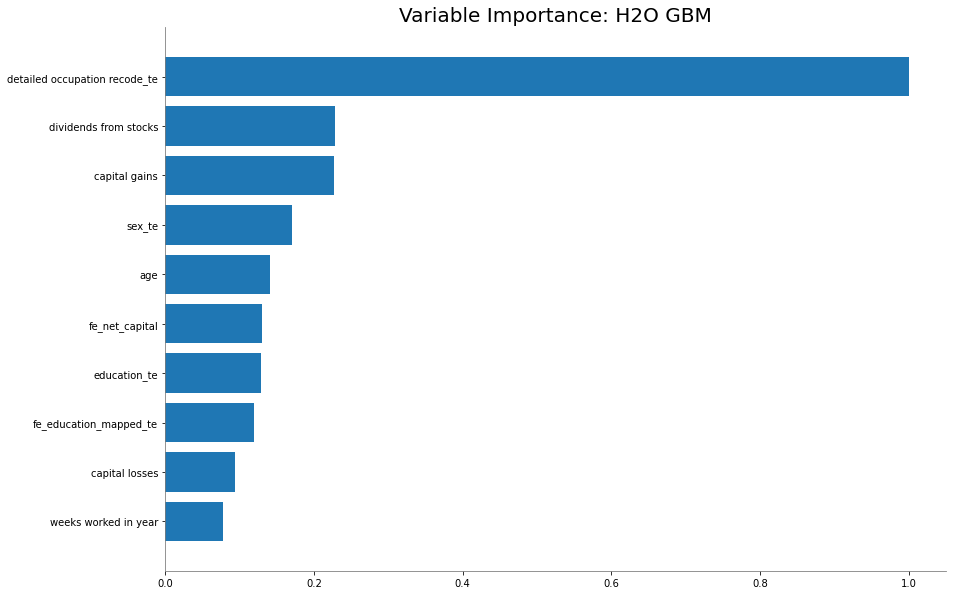

In [56]:
gbm_model_final.varimp_plot()

<div class=discuss>
The above makes intuitive sense that a persons job would be a feature with good signal when predicting how much a person earns. The dividends from stock and capital gain are interesting and might be kind of considered data leakage depending on how the target is defined. If dividend income is part of income, and we are trying to predict income then it seem like data leakage. If the income we are trying to predict is independent from dividend then it is less of a data leakage problem. All of this would depend on the use case of such a model, domain knowledge, and how and when this data is gathered. An interesting discussion could probably be had about all of the above features, but none them seem too strange.
</div>

#### Male | Female Comparison  
Sex is an interesting feature because often in regulated industries where models are used to make or influence decisions those model can be audited and scrutinous for unwanted bias. Thus taking a deeper look is warranted for such features before applying them to sensitive use cases.

In [80]:
# split dataset on sex
hdf_test_women = hdf_test_te[hdf_test_te['sex'] == ' Female']
hdf_test_men = hdf_test_te[hdf_test_te['sex'] == ' Male']

In [81]:
# generate metrics report
female_metrics = gbm_model_final.model_performance(hdf_test_women)
male_metrics = gbm_model_final.model_performance(hdf_test_men)

In [89]:
# See individual model performance for each sex
female_f1 = female_metrics.F1()[0][1]
male_f1 = male_metrics.F1()[0][1]
female_acc = female_metrics.accuracy()[0][1]
male_acc = male_metrics.accuracy()[0][1]
print(f"Female |    Acc: {female_acc:.3f}   F1: {female_f1:.3f}")
print(f"Male   |    Acc: {male_acc:.3f}   F1: {male_f1:.3f}")

Female |    Acc: 0.979   F1: 0.478
Male   |    Acc: 0.935   F1: 0.659


<div class=discuss>
The accuracy between the different groups is quite noticable, with a higher accuracy for the female data, but quite a lower F1 score, which in this case we have decided is the more appropriate metric due to false negative and false positive inclusions for imbalanced targets. We can get a fuller picture with the confusion matrix of each group.
</div>

In [87]:
female_metrics.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2875036427811803: 


,,0,1,Error,Rate
0,0,50045.0,441.0,0.0087,(441.0/50486.0)
1,1,757.0,548.0,0.5801,(757.0/1305.0)
2,Total,50802.0,989.0,0.0231,(1198.0/51791.0)


In [83]:
male_metrics.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2863445252510318: 


,,0,1,Error,Rate
0,0,40904.0,2186.0,0.0507,(2186.0/43090.0)
1,1,1411.0,3470.0,0.2891,(1411.0/4881.0)
2,Total,42315.0,5656.0,0.075,(3597.0/47971.0)


<div class=discuss>
The higher false negative rate (58%) for women compared to men (29%) indicates we are incorrectly predicting women are not making more than 50K at a much higher rate than the error rate for men. This kind of bias could be a red flag depending on the use case for regulated industries. Although no use case is known here, it is good to keep this in mind for real world applications.
</div>

## Conclusion
This was quite an interesting dataset with many good features. It was a bit challenging to parse the metadata file to connect features with the dataset, and maybe could be done manually, but on larger data manual tasks are sometimes not an option. The data was quite clean though which made exploration quick and enjoyable. Lacking domain knowledge in a given dataset make exploration a bit slower, and hesistant to remove features without knowledge of what they are, although possibly many of the similar features could have been removed leading to less model complexity without loss of signal, but this would be a tuning task that was not tackled here. The engineered features did not greatly improve model performance, but there are probably many more features that could be engineered so this is still a valuable task.